Thinking about how to parametrize $p(P)$, $p(e | P)$, $p(q)$ in a binary star population inference.

In [170]:
import pathlib
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import beta, norm
import twobody as tb

from tqdm.notebook import tqdm, trange

from hq.config import Config

import aesara_theano_fallback.tensor as tt
import pymc3 as pm
import pymc3_ext as pmx

In [6]:
vac_path = pathlib.Path('../../vac-pipeline/')

In [2]:
allstar = at.QTable.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-synspec.fits')
allvisit = at.QTable.read(
    vac_path / 'cache/allVisit-dr17-synspec-min3-calibverr.fits'
)

In [7]:
sh = at.Table.read(vac_path / 'catalog-helpers/starhorse/starhorse_mass_m2_min.fits')

In [8]:
c = Config(vac_path / 'hq-config/config.yml')

In [9]:
metadata = at.QTable.read(c.metadata_file)
metadata = at.join(metadata, allstar, keys='APOGEE_ID')
metadata = at.join(metadata, sh, keys='APOGEE_ID', join_type='left')
metadata = at.unique(metadata, keys='APOGEE_ID')

# HACK:
metadata['mass1_50'][~np.isin(metadata['APOGEE_ID'], sh['APOGEE_ID'])] = np.nan
metadata['mass2_min_50'][~np.isin(metadata['APOGEE_ID'], sh['APOGEE_ID'])] = np.nan

len(metadata)

358350

In [82]:
# FGK Main sequence box:
fgk = metadata[
    (metadata['VSINI'].filled(0.) < 50.) &    
    (metadata['TEFF'] < 6000) & (metadata['TEFF'] > 4500) &
    (metadata['LOGG'] > 4.2)
]

subgiants = metadata[
    (metadata['VSINI'].filled(0.) < 50.) &    
    (metadata['TEFF'] < 5500) & (metadata['TEFF'] > 4700) &
    (metadata['LOGG'] > 3.2) & (metadata['LOGG'] < 4.1)
]

rgb = metadata[
    (metadata['VSINI'].filled(0.) < 50.) &    
    (metadata['TEFF'] < 5200) & (metadata['TEFF'] > 4000) &
    (metadata['LOGG'] > 1) & (metadata['LOGG'] < 2.4)
]

print(len(fgk), len(subgiants), len(rgb))

stars = fgk
# stars = subgiants
# stars = rgb
uni = stars[stars['unimodal']]
len(uni)

56287 23801 94179


740

(5.0, 0.0)

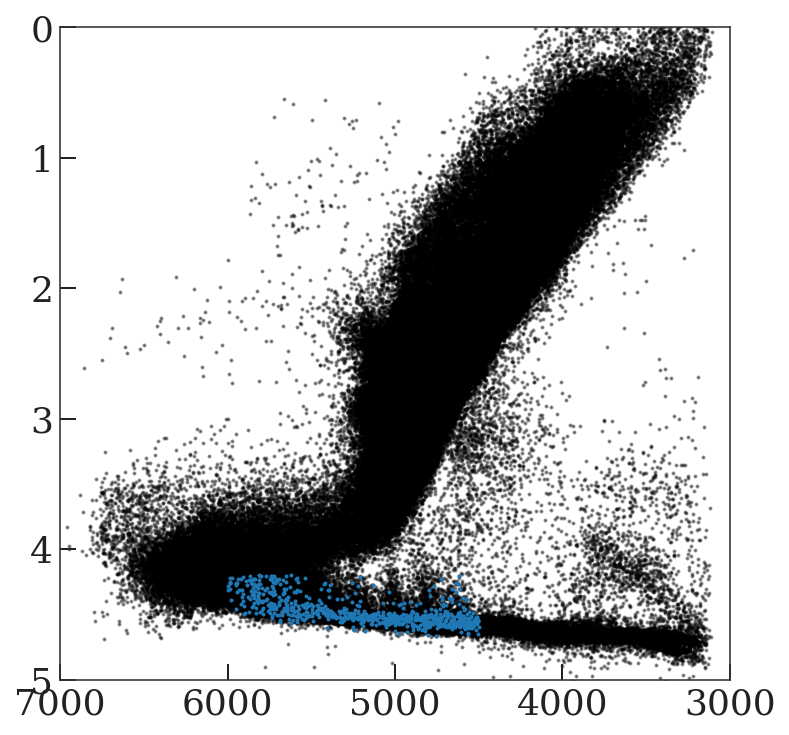

In [83]:
plt.scatter(metadata['TEFF'], metadata['LOGG'], s=1, alpha=0.4)
plt.scatter(uni['TEFF'], uni['LOGG'], s=1, alpha=1)
plt.xlim(7000, 3000)
plt.ylim(5, 0)

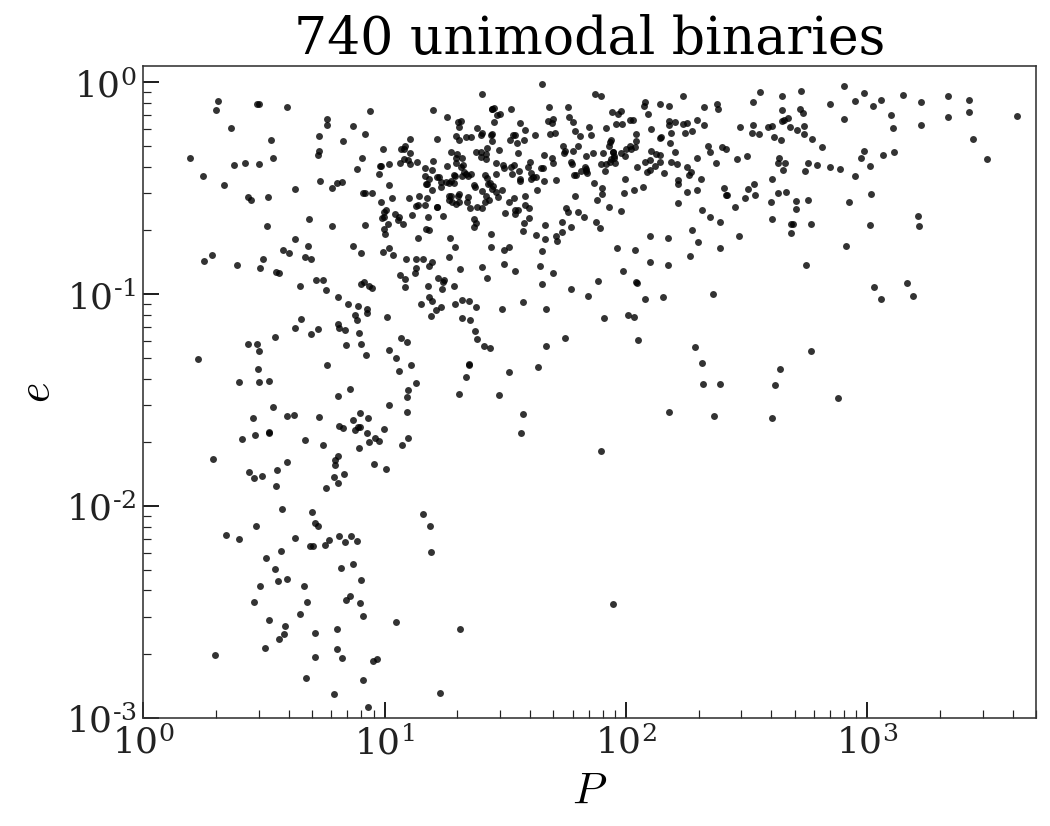

In [84]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(uni['MAP_P'], uni['MAP_e'], c='k',
            marker='o', lw=0, s=12, alpha=0.8)
plt.title(f'{len(uni)} unimodal binaries')

plt.xscale('log')
plt.yscale('log')

plt.xlim(1, 5e3)
plt.ylim(1e-3, 1.2e0)

plt.xlabel('$P$')
plt.ylabel('$e$')

fig.set_facecolor('w')

# Eccentricity

$p(e | P)$

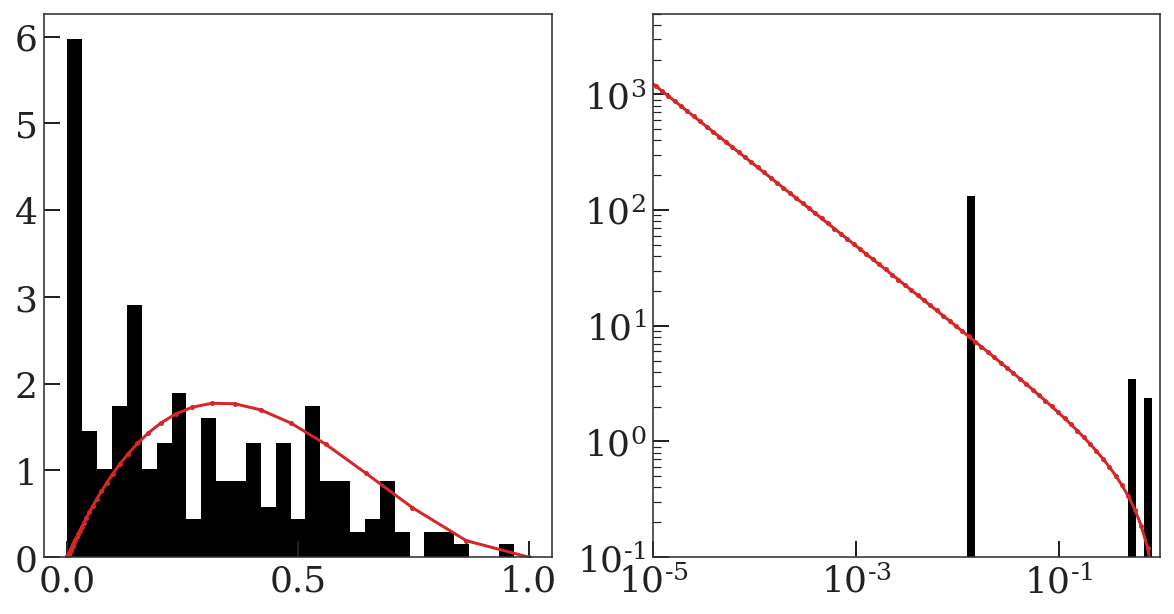

In [80]:
_grid = np.geomspace(1e-8, 1, 128)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.hist(uni['MAP_e'][uni['MAP_P'] > 15*u.day].value, 
        density=True,
        bins=np.linspace(0, 1, 32));

ax.plot(_grid, beta.pdf(_grid, 2., 3), color='tab:red')

# ---

ax = axes[1]
ax.hist(uni['MAP_e'][uni['MAP_P'] < 15*u.day].value, 
        density=True,
        bins=np.geomspace(1e-5, 1e0, 64));

ax.plot(_grid, beta.pdf(_grid, 0.3, 2), color='tab:red')

ax.set_xlim(1e-5, 1)
ax.set_ylim(1e-1, 5e3)

ax.set_xscale('log')
ax.set_yscale('log')

In [81]:
logP_data = np.log10(uni['MAP_P'].value)
loge_data = np.log10(uni['MAP_e'])
e_data = np.asarray(uni['MAP_e']).astype(float)

loge_data.min(), loge_data.max()

(<Quantity -5.3956465>, <Quantity -0.01554714>)

In [15]:
logP_bins_l = np.arange(0, 3, 0.5) + np.log10(3)
logP_bins_r = logP_bins_l + 0.75

alphas = []
for l, r in zip(logP_bins_l, logP_bins_r):
    Pmask = (logP_data > l) & (logP_data <= r)
    this_loge_data = loge_data[Pmask]
    
    with pm.Model() as model:
        w = pm.Dirichlet('w', a=np.array([1., 1.]))

        comp1 = pm.Beta.dist(5, 1.5)
        comp2 = pm.TruncatedNormal.dist(-2, 2, 
                                        lower=-8, upper=0)
        # pm.Mixture('lnlike', w=w, comp_dists=[comp1, comp2], 
        #            observed=this_loge_data)
        pm.Potential('lnlike', 
                     pm.logaddexp(tt.log(w[0]) + comp1.logp((this_loge_data - -2) / 2),
                                  tt.log(w[1]) + comp2.logp(this_loge_data)))

        res = pmx.optimize()
    
    alpha = res['w'][0] / np.sum(res['w'])
    alphas.append(alpha)

optimizing logp for variables: [w]


message: Optimization terminated successfully.
logp: -282.77478210609576 -> -282.7487009442618
optimizing logp for variables: [w]


message: Optimization terminated successfully.
logp: -76.33036797561672 -> 12.645308789237333


optimizing logp for variables: [w]


message: Optimization terminated successfully.
logp: -6.458623746679405 -> 83.61179135308079


optimizing logp for variables: [w]


message: Optimization terminated successfully.
logp: -2.819732622513915 -> 62.34391110556288


optimizing logp for variables: [w]


message: Optimization terminated successfully.
logp: 0.7692151748452513 -> 40.56613888661065


optimizing logp for variables: [w]


message: Optimization terminated successfully.
logp: 1.0484363367005929 -> 14.173512420344535


(0.0, 1.0)

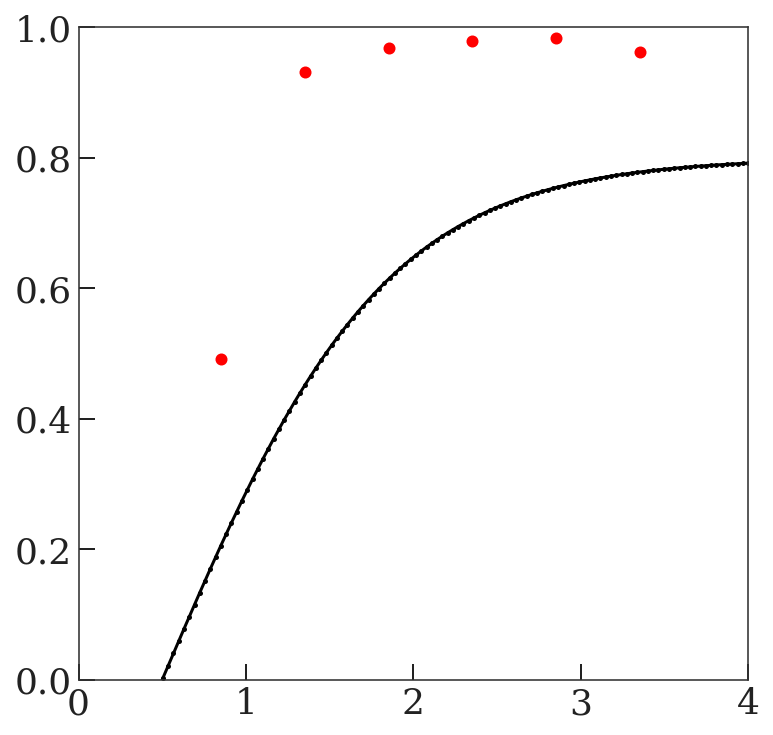

In [16]:
grid = np.linspace(0, 4, 128)
x0 = 0.5
plt.plot(grid, 0.8 * np.tanh(3 * (grid - x0) / 4))

plt.scatter(0.5 * (logP_bins_l + logP_bins_r), alphas, color='r')

plt.xlim(0, 4)
plt.ylim(0, 1)

In [17]:
with pm.Model() as model:
    a1 = pm.Uniform('a1', 0.5, 1)
    a2 = pm.Uniform('a2', 0.5, 10)
    logP0 = pm.Uniform('logP0', 0, 2)
    alpha = a1 * tt.tanh(a2 * (logP_data - logP0) / 4)
    alpha = tt.where((logP_data - logP0) < 0, 0, alpha)

#     comp1 = pm.TruncatedNormal.dist(np.log10(0.5), 0.2, 
#                                     lower=-8, upper=0)
#     comp2 = pm.TruncatedNormal.dist(-2, 2, 
#                                     lower=-8, upper=0)

    comp1 = pm.Beta.dist(2, 3)
    comp2 = pm.Beta.dist(0.3, 2)
    
    ll1 = pm.Deterministic('ll1', 
                           tt.log(alpha) + comp1.logp(e_data))
    ll2 = pm.Deterministic('ll2', 
                           tt.log(1 - alpha) + comp2.logp(e_data))

    pm.Potential('lnlike', pm.logaddexp(ll1, ll2))

    res = pmx.optimize(start={'a1': 0.8, 'a2': 3, 'logP0': 0.5})

optimizing logp for variables: [logP0, a2, a1]


message: Desired error not necessarily achieved due to precision loss.
logp: 304.5979545048765 -> 365.69918440954433


In [18]:
# res

In [19]:
prob = np.exp(res['ll1'] - np.logaddexp(res['ll1'], res['ll2']))
prob

array([8.73997954e-01, 9.91540447e-01, 9.92160782e-01, 9.30810051e-01,
       8.76595509e-02, 9.91247226e-01, 0.00000000e+00, 9.71607129e-01,
       4.55473248e-01, 9.91924458e-01, 9.93480189e-01, 8.67609560e-01,
       6.21077225e-01, 9.23408551e-01, 9.92602856e-01, 4.59421412e-01,
       9.89230523e-01, 0.00000000e+00, 9.93046160e-01, 9.49335326e-01,
       0.00000000e+00, 9.79131344e-01, 9.86932769e-01, 9.24777790e-01,
       1.06099972e-01, 8.87179898e-01, 9.75568368e-01, 9.89644941e-01,
       8.62389079e-01, 9.45245175e-01, 9.63353006e-01, 0.00000000e+00,
       4.82311488e-01, 3.45928660e-05, 9.71151688e-01, 0.00000000e+00,
       9.89414084e-01, 9.93474622e-01, 0.00000000e+00, 9.85126912e-01,
       9.82926100e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.36635961e-02, 9.82730500e-01, 3.02148515e-02, 9.80893629e-01,
       0.00000000e+00, 9.24932371e-01, 0.00000000e+00, 5.00429100e-01,
       5.87298379e-02, 9.75903925e-01, 9.56505462e-01, 8.68919519e-01,
      

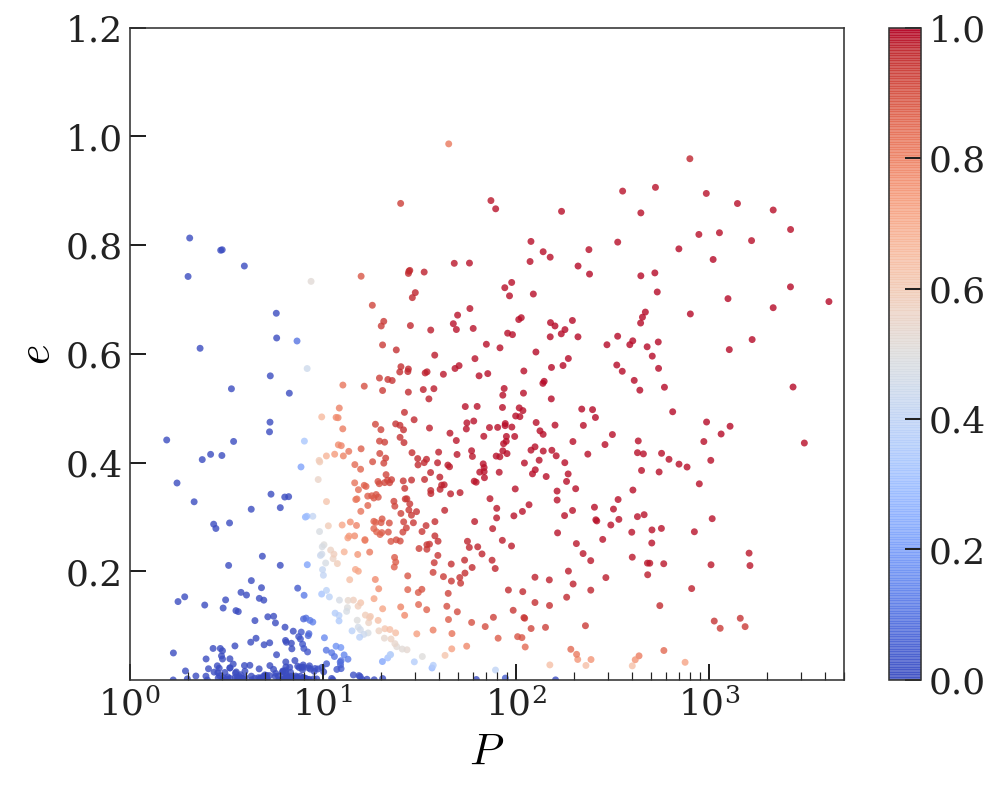

In [20]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(uni['MAP_P'], uni['MAP_e'], c=prob,
            marker='o', lw=0, s=12, alpha=0.8, cmap='coolwarm',
            vmin=0, vmax=1)

cb = plt.colorbar()

plt.xscale('log')
# plt.yscale('log')

plt.xlim(1, 5e3)
plt.ylim(1e-4, 1.2e0)

plt.xlabel('$P$')
plt.ylabel('$e$')

fig.set_facecolor('w')

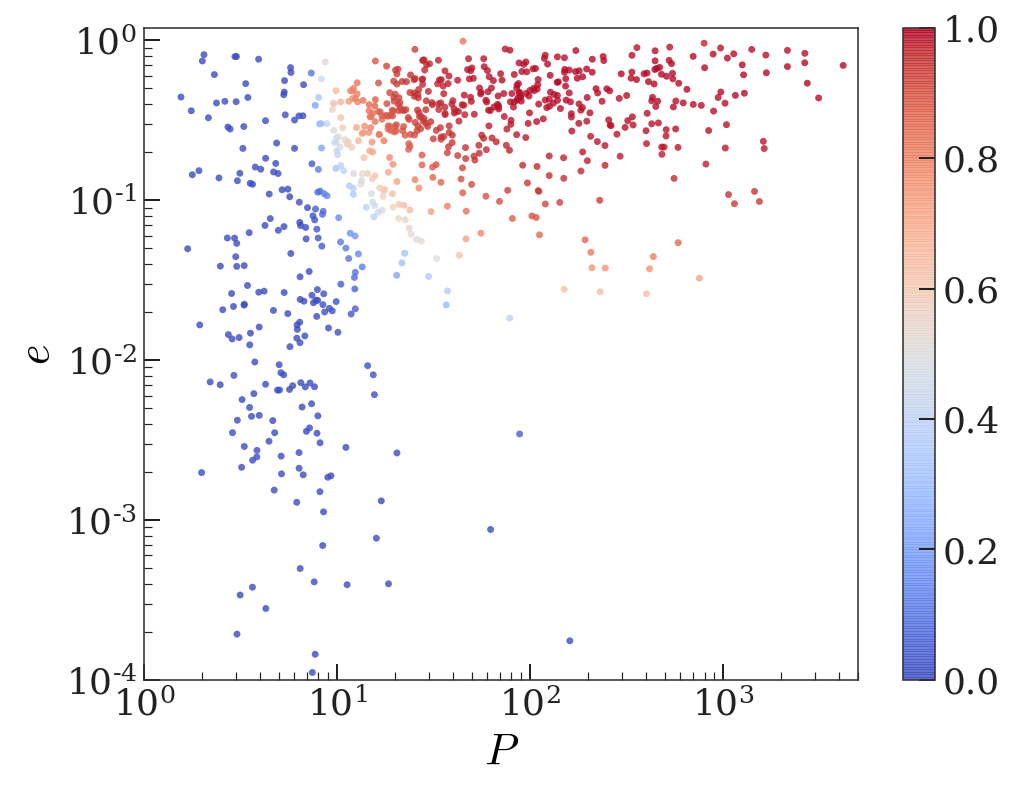

In [21]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(uni['MAP_P'], uni['MAP_e'], c=prob,
            marker='o', lw=0, s=12, alpha=0.8, cmap='coolwarm',
            vmin=0, vmax=1)

cb = plt.colorbar()

plt.xscale('log')
plt.yscale('log')

plt.xlim(1, 5e3)
plt.ylim(1e-4, 1.2e0)

plt.xlabel('$P$')
plt.ylabel('$e$')

fig.set_facecolor('w')

(0.0, 1.0)

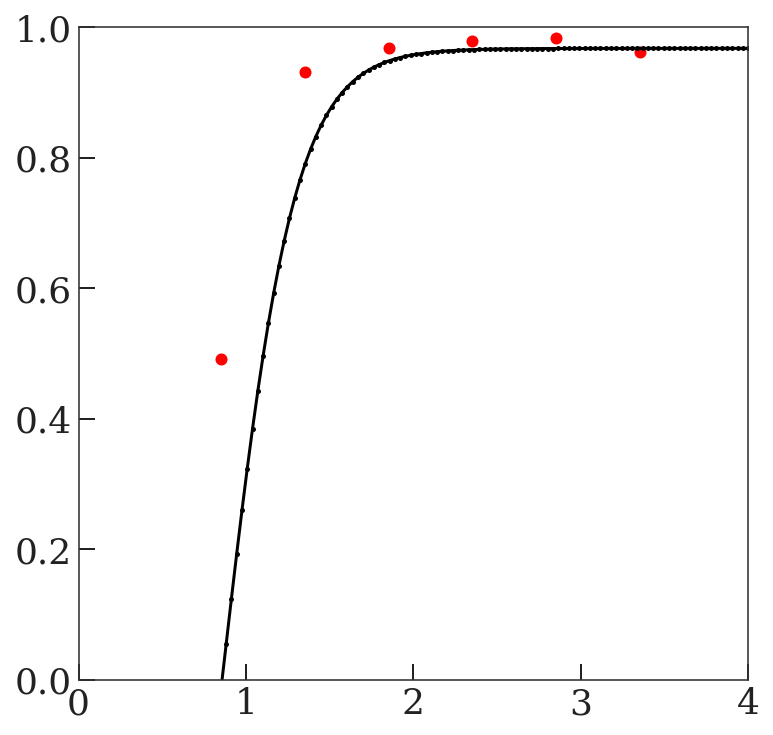

In [85]:
grid = np.linspace(0, 4, 128)
plt.plot(grid, res['a1'] * np.tanh(res['a2'] * (grid - res['logP0']) / 4))
plt.scatter(0.5 * (logP_bins_l + logP_bins_r), alphas, color='r')
plt.xlim(0, 4)
plt.ylim(0, 1)

# Period

$p(P)$

Use the usual log-normal?

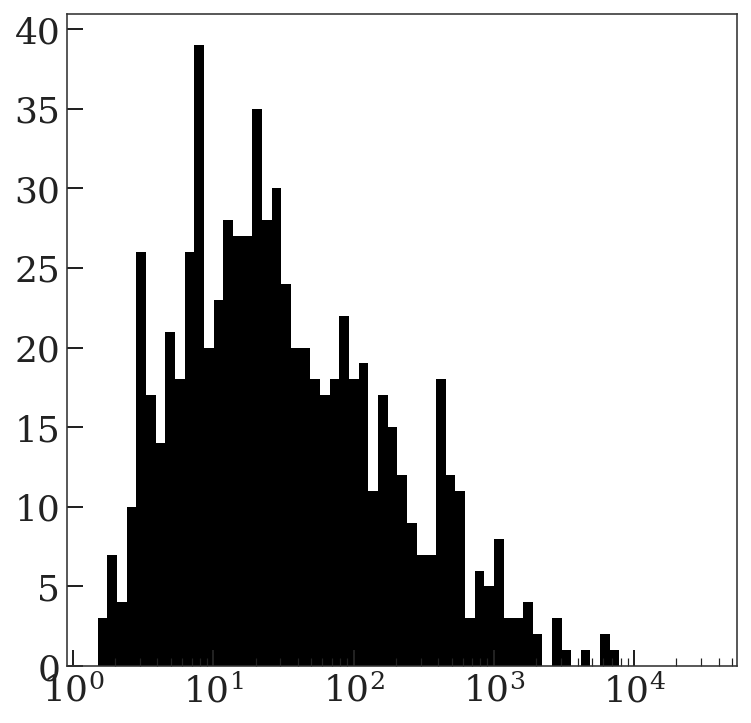

In [23]:
bins = np.geomspace(1.5, 32768, 64)

plt.hist(uni['MAP_P'].value, bins=bins)
plt.xscale('log')

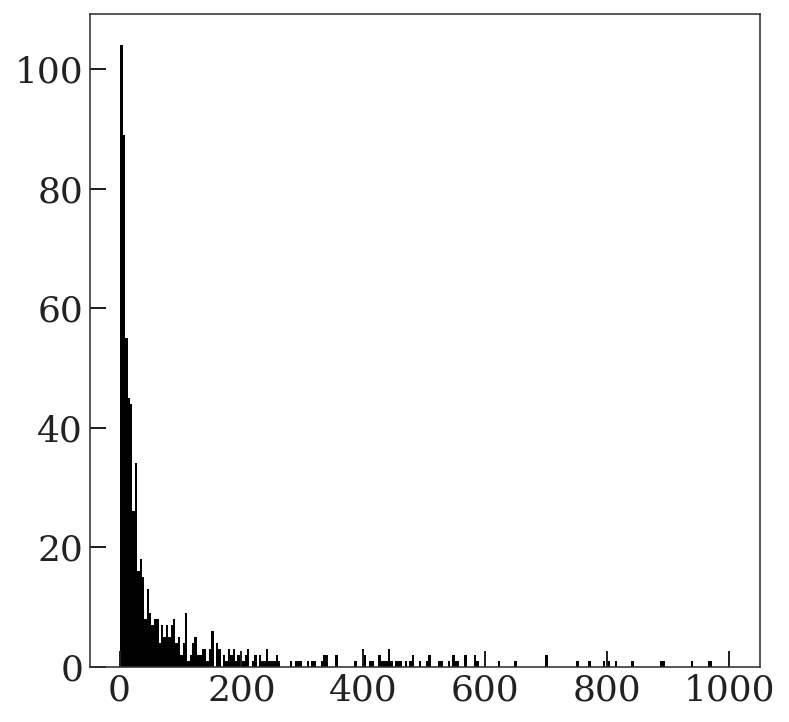

In [24]:
bins = np.linspace(1.5, 1000, 256)
plt.hist(uni['MAP_P'].value, bins=bins);

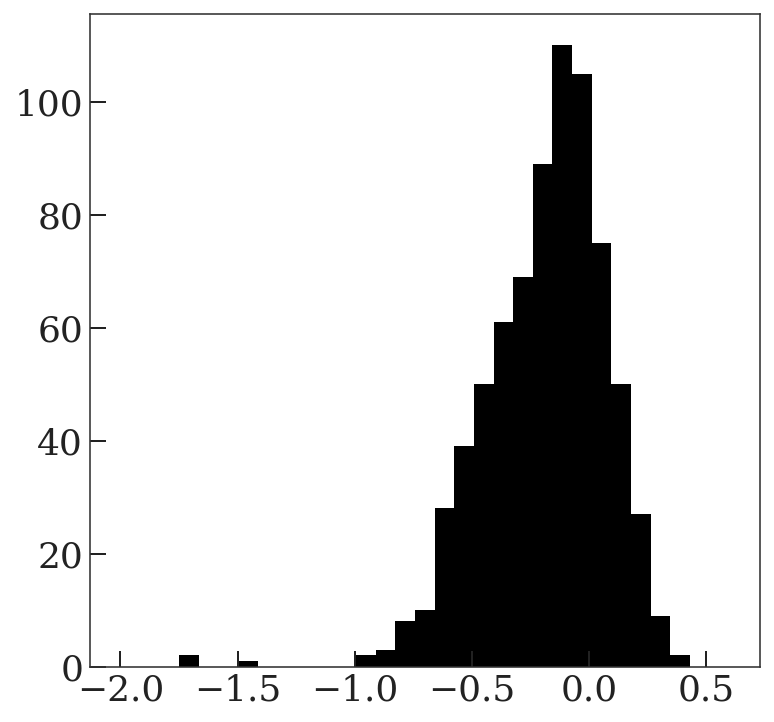

In [25]:
plt.hist(uni['M_H'], bins=np.linspace(-2, 0.6, 32));

# Mass ratio

$p(q)$

Truncnorm?

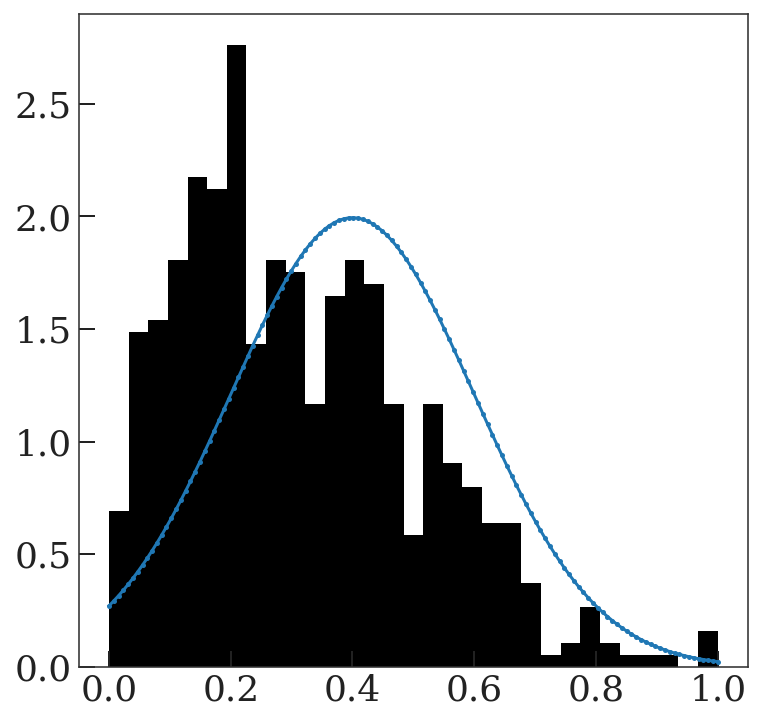

In [26]:
plt.hist(uni['mass2_min_50'] / uni['mass1_50'], 
         bins=np.linspace(0, 1, 32),
         density=True);

_grid = np.linspace(0, 1, 128)
plt.plot(_grid, norm.pdf(_grid, 0.4, 0.2))

Text(0.5, 0.98, 'APOGEE unimodal FGK binaries (740 systems)')

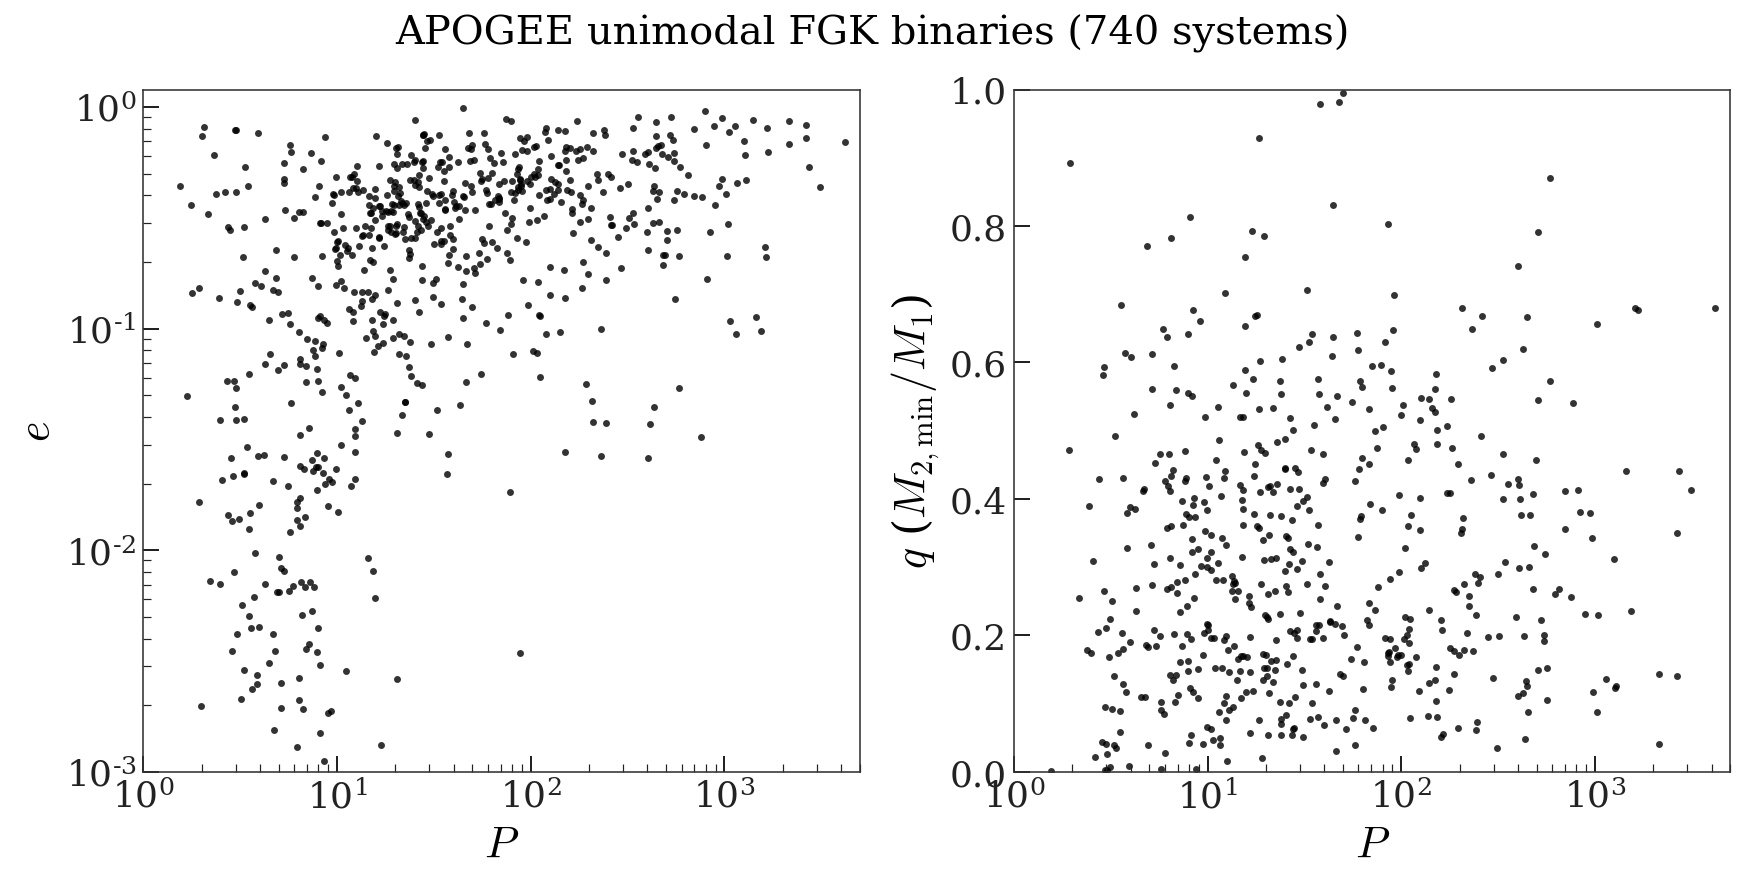

In [27]:
qq = uni['mass2_min_50'] / uni['mass1_50']

fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True,
                         constrained_layout=True)

ax = axes[0]
ax.scatter(uni['MAP_P'], uni['MAP_e'], c='k',
            marker='o', lw=0, s=12, alpha=0.8)

ax.set(
    xscale='log',
    yscale='log',
    xlim=(1, 5e3),
    ylim=(1e-3, 1.2e0),
    xlabel='$P$',
    ylabel='$e$'
)

# ---

ax = axes[1]
ax.scatter(uni['MAP_P'], qq, c='k',
            marker='o', lw=0, s=12, alpha=0.8)

ax.set(
    ylim=(0, 1),
    xlabel='$P$',
    ylabel=r'$q$ ($M_{2, {\rm min}}/M_1$)'
)

fig.set_facecolor('w')
fig.suptitle(f"APOGEE unimodal FGK binaries ({len(uni)} systems)", 
             fontsize=20)

# Simulate

In [159]:
a1 = res['a1']
a2 = res['a2']
logP0 = res['logP0']

with pm.Model() as model:
    # Period
    logP = pm.TruncatedNormal('logP', 3.5, 2., 
                              lower=np.log10(1.5), upper=5.)
    P = pm.Deterministic('P', 10 ** logP)
    
    # Eccentricity
    alpha = a1 * tt.tanh(a2 * (logP - logP0) / 4)
    alpha = tt.where((logP - logP0) < 0, 0, alpha)
    alpha = tt.where(logP > np.log10(350), 1, alpha)

    comp1 = pm.Beta.dist(2, 3)
    comp2 = pm.Beta.dist(0.3, 2)

    ecc = pm.Mixture('ecc', w=[alpha, 1 - alpha], comp_dists=[comp1, comp2])
    
    # Mass ratio
    q = pm.TruncatedNormal('q', 0.4, 0.2, lower=0., upper=1)
    
#     sim_samples = pmx.sample(draws=10000, tune=2000, 
#                              return_inferencedata=True)

In [160]:
with model:
    sim_samples = pm.sample_prior_predictive(
        samples=100_000, 
        random_seed=42
    )

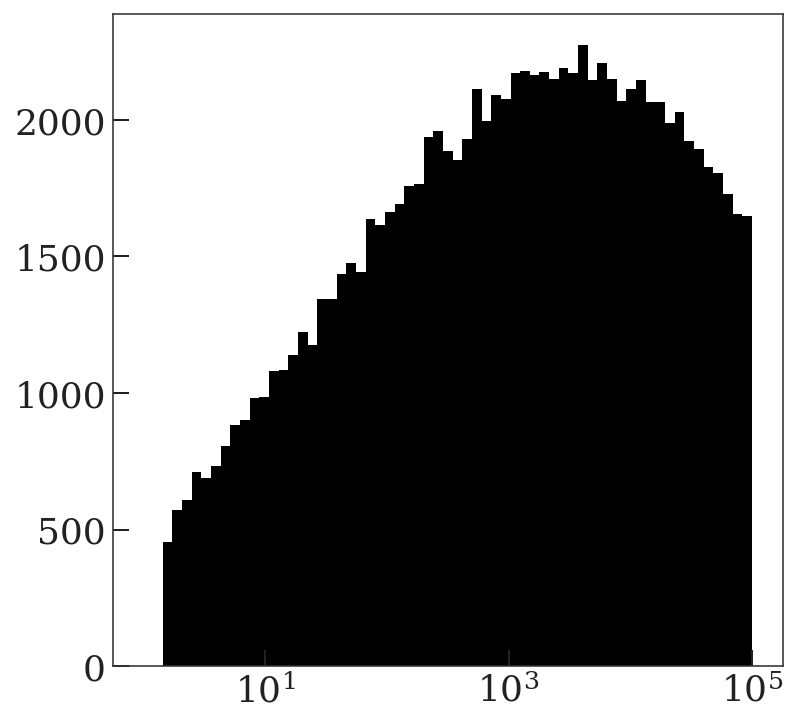

In [161]:
bins = np.geomspace(1., sim_samples['P'].max(), 64)

plt.hist(sim_samples['P'], bins=bins)
plt.xscale('log')

In [162]:
len(sim_samples['P']), (sim_samples['P'] > 2000).sum()

(100000, 43112)

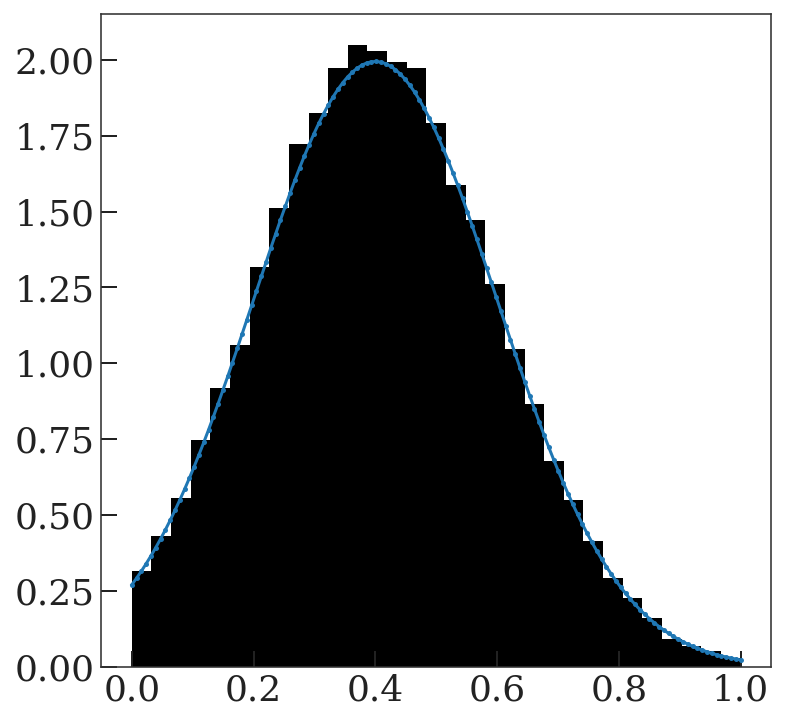

In [163]:
plt.hist(sim_samples['q'],
         bins=np.linspace(0, 1, 32),
         density=True);

_grid = np.linspace(0, 1, 128)
plt.plot(_grid, norm.pdf(_grid, 0.4, 0.2))

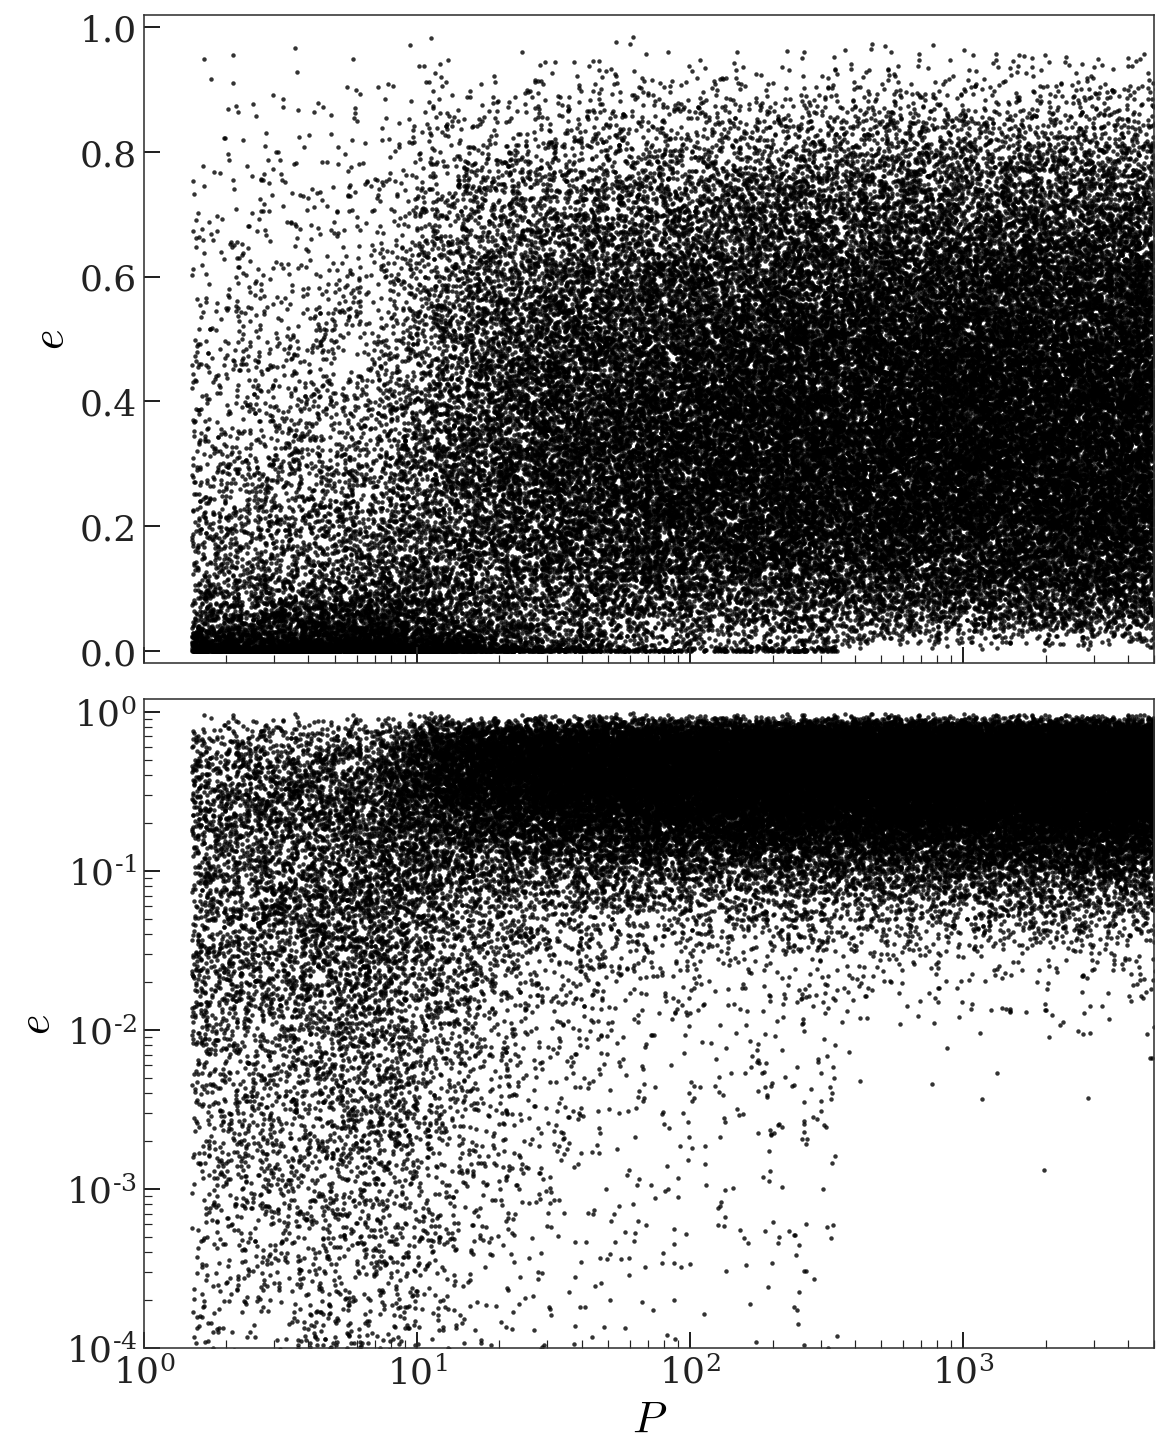

In [164]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, 
                         constrained_layout=True)

for ax in axes: 
    ax.scatter(sim_samples['P'], 
               sim_samples['ecc'],
               marker='o', lw=0, s=5, alpha=0.8)
    ax.set_ylabel('$e$')

ax.set_xscale('log')

axes[0].set_ylim(-0.02, 1.02)

axes[1].set_yscale('log')
axes[1].set_ylim(1e-4, 1.2e0)

ax.set_xlim(1, 5e3)

axes[1].set_xlabel('$P$')

fig.set_facecolor('w')

# Generate RV curves

Sample, with replacement, from sources in parent sample to get observation times:

In [165]:
N_sim = len(sim_samples['P'])

In [188]:
rng = np.random.default_rng(seed=42)

sim_samples_tbl = at.QTable({k: sim_samples[k] for k in ['P', 'ecc', 'q']})
sim_samples_tbl['P'] = sim_samples_tbl['P'] * u.day
sim_samples_tbl.rename_column('ecc', 'e')

sim_samples_tbl['m1'] = rng.uniform(0.8, 1.2, size=N_sim) * u.Msun
sim_samples_tbl['m2'] = sim_samples['q'] * sim_samples_tbl['m1']
sim_samples_tbl['i'] = np.arccos(rng.uniform(0, 1, size=N_sim) * u.one)

sim_samples_tbl['omega'] = rng.uniform(0, 2*np.pi, size=N_sim) * u.rad
sim_samples_tbl['M0'] = rng.uniform(0, 2*np.pi, size=N_sim) * u.rad
sim_samples_tbl['t0'] = Time(55555, format='mjd')
sim_samples_tbl['v0'] = rng.normal(0, 100, size=N_sim) * u.km/u.s


fake_allvisit_rows = {'APOGEE_ID': [], 'JD': [], 'VHELIO': [], 'CALIB_VERR': []}
for i, row in enumerate(sim_samples_tbl):
    print(i, end='\r')
    star = stars[rng.choice(len(stars))]
    visits = allvisit[allvisit['APOGEE_ID'] == star['APOGEE_ID']]
    
    jd_times = visits['JD']
    
    elem = tb.TwoBodyKeplerElements(
        **{k: v for k, v in dict(row).items() 
           if k in tb.TwoBodyKeplerElements.names
    })
    
    orbit = tb.KeplerOrbit(elem.primary)
    t = Time(jd_times, format='jd', scale='tcb')
    rv = orbit.radial_velocity(t)
    rv_err = visits['CALIB_VERR'] * u.km/u.s
    rv = rng.normal(rv.value, rv_err.value) * rv.unit
    
    fake_allvisit_rows['APOGEE_ID'].extend([star['APOGEE_ID'] 
                                            for i in range(len(visits))])
    fake_allvisit_rows['JD'].extend(jd_times)
    fake_allvisit_rows['VHELIO'].extend(rv)
    fake_allvisit_rows['CALIB_VERR'].extend(rv_err)

In [192]:
fake_allvisit_tbl = at.QTable(fake_allvisit_rows)

In [194]:
fake_allvisit_tbl.write('../cache/simulated-allvisit.fits')